## Random Forest & GBM Development for Energy Consumption
### John Matune
### 2/5/19

In [21]:
# imports

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
import xgboost as xgb

In [4]:
df = pd.read_csv('../processed/consumption_master_with_SF.csv')

## i guess i have to bring in consumption weather and join it to the consumption dataset

c_weather = pd.read_csv('../raw/powercity_weather_consumption.csv')
c_weather.head().T

,0,1,2,3,4
City,Power City,Power City,Power City,Power City,Power City
Year,Consumption,Consumption,Consumption,Consumption,Consumption
Month,1,1,1,1,1
Day,1,1,1,1,1
Hour,1,2,3,4,5
Cloud_Cover_Fraction,1,1,1,1,1
Dew_Point,-8.9,-9.4,-10.6,-10.6,-11.7
Humidity_Fraction,0.81,0.84,0.81,0.81,0.77
Precipitable_Water,6,6,6,6,6
Temperature,-6.1,-7.2,-7.8,-7.8,-8.3


In [5]:
# create datetime index to join both tables
c_weather['Hour_str'] = [str(x-1) if len(str(x-1))==2 else '0'+str(x-1) for x in c_weather['Hour']]
c_weather['datetime_str'] = ['1900-'+str(x)+'-'+str(y)+' '+str(z)+':00:00' for x, y, z in zip(c_weather.Month, c_weather.Day, c_weather.Hour_str)]
c_weather['datetime'] = pd.to_datetime(c_weather.datetime_str, infer_datetime_format=True)

c_weather.head()

# set new index
#c_weather.set_index()

,City,Year,Month,Day,Hour,Cloud_Cover_Fraction,Dew_Point,Humidity_Fraction,Precipitable_Water,Temperature,Visibility,Hour_str,datetime_str,datetime
0,Power City,Consumption,1,1,1,1.0,-8.9,0.81,6,-6.1,4.0,00,1900-1-1 00:00:00,1900-01-01 00:00:00
1,Power City,Consumption,1,1,2,1.0,-9.4,0.84,6,-7.2,4.0,01,1900-1-1 01:00:00,1900-01-01 01:00:00
2,Power City,Consumption,1,1,3,1.0,-10.6,0.81,6,-7.8,4.0,02,1900-1-1 02:00:00,1900-01-01 02:00:00
3,Power City,Consumption,1,1,4,1.0,-10.6,0.81,6,-7.8,4.0,03,1900-1-1 03:00:00,1900-01-01 03:00:00
4,Power City,Consumption,1,1,5,1.0,-11.7,0.77,6,-8.3,4.0,04,1900-1-1 04:00:00,1900-01-01 04:00:00


In [6]:
c_weather.dtypes

City                            object
Year                            object
Month                            int64
Day                              int64
Hour                             int64
Cloud_Cover_Fraction           float64
Dew_Point                      float64
Humidity_Fraction              float64
Precipitable_Water               int64
Temperature                    float64
Visibility                     float64
Hour_str                        object
datetime_str                    object
datetime                datetime64[ns]
dtype: object

In [7]:
c_weather = c_weather.set_index(pd.DatetimeIndex(c_weather['datetime']))

In [8]:
c_weather.drop(['datetime', 'datetime_str', 'Hour_str', 'Year', 'City'], axis=1, inplace=True)
c_weather.head()

,Month,Day,Hour,Cloud_Cover_Fraction,Dew_Point,Humidity_Fraction,Precipitable_Water,Temperature,Visibility
datetime,,,,,,,,,
1900-01-01 00:00:00,1,1,1,1.0,-8.9,0.81,6,-6.1,4.0
1900-01-01 01:00:00,1,1,2,1.0,-9.4,0.84,6,-7.2,4.0
1900-01-01 02:00:00,1,1,3,1.0,-10.6,0.81,6,-7.8,4.0
1900-01-01 03:00:00,1,1,4,1.0,-10.6,0.81,6,-7.8,4.0
1900-01-01 04:00:00,1,1,5,1.0,-11.7,0.77,6,-8.3,4.0


In [9]:
for field in ['Month', 'Day', 'Hour']:
    c_weather[field] = c_weather[field].astype(str)

c_weather.dtypes

Month                    object
Day                      object
Hour                     object
Cloud_Cover_Fraction    float64
Dew_Point               float64
Humidity_Fraction       float64
Precipitable_Water        int64
Temperature             float64
Visibility              float64
dtype: object

In [10]:
# join to main consumption data
df = df.set_index(pd.DatetimeIndex(df['Time']))
df.drop('Time', inplace=True, axis=1)
df.dtypes
df.head(25)


,FOOD_SERVICE,GROCERY,HEALTH_CARE,K12_SCHOOLS,LODGING,OFFICE,RESIDENTIAL,STAND_ALONE_RETAIL,Weekdays,HolidayName,...,RESIDENTIAL_SF,SA_RTL_SF,FOOD_SVC_TOTAL,GROCERY_TOTAL,HEALTH_CARE_TOTAL,K12_TOTAL,LODGING_TOTAL,OFFICE_TOTAL,RESIDENTIAL_TOTAL,SA_RTL_TOTAL
Time,,,,,,,,,,,,,,,,,,,,,
1900-01-01 01:00:00,0.005416,0.002030,0.002390,0.000818,0.001209,0.001911,0.000541,0.000491,Sun,New Year's Day,...,8.482341e+07,971961.735665,5240.358908,1096.297148,2307.216574,1984.355690,1125.486086,19108.976855,45875.739073,477.001885
1900-01-01 02:00:00,0.003789,0.002032,0.002443,0.000815,0.001215,0.001664,0.000523,0.000499,Sun,New Year's Day,...,8.482341e+07,971961.735665,3666.285758,1097.042106,2358.377936,1977.208735,1131.096791,16635.496277,44355.771468,485.313908
1900-01-01 03:00:00,0.003797,0.001977,0.002413,0.000824,0.001149,0.002005,0.000517,0.000505,Sun,New Year's Day,...,8.482341e+07,971961.735665,3673.960332,1067.347195,2329.567788,1998.867496,1069.825145,20052.796510,43877.825496,490.808116
1900-01-01 04:00:00,0.003802,0.002068,0.002406,0.000817,0.001164,0.001697,0.000514,0.000507,Sun,New Year's Day,...,8.482341e+07,971961.735665,3678.382266,1116.774474,2322.396505,1982.546991,1083.443560,16970.896270,43589.612521,492.574948
1900-01-01 05:00:00,0.003861,0.002176,0.002428,0.000825,0.001211,0.002016,0.000575,0.000510,Sun,New Year's Day,...,8.482341e+07,971961.735665,3736.219406,1175.213337,2344.384257,2001.978486,1127.795007,20161.026603,48802.994869,495.828201
1900-01-01 06:00:00,0.005475,0.002133,0.002428,0.000819,0.001317,0.001707,0.000708,0.000512,Sun,New Year's Day,...,8.482341e+07,971961.735665,5297.753197,1151.933455,2344.087307,1988.044910,1226.523277,17068.217656,60068.578241,497.266218
1900-01-01 07:00:00,0.011265,0.002751,0.002672,0.000825,0.001738,0.002039,0.000863,0.000515,Sun,New Year's Day,...,8.482341e+07,971961.735665,10899.968385,1485.322602,2579.123223,2002.441701,1618.414467,20389.164477,73170.902234,500.855187
1900-01-01 08:00:00,0.011246,0.002952,0.002654,0.000811,0.002038,0.001738,0.000944,0.000517,Sun,New Year's Day,...,8.482341e+07,971961.735665,10880.914457,1594.136249,2562.145474,1968.781085,1897.651049,17378.428326,80086.079642,502.612688
1900-01-01 09:00:00,0.008233,0.003439,0.002884,0.000731,0.002322,0.001860,0.000753,0.000943,Sun,New Year's Day,...,8.482341e+07,971961.735665,7966.313362,1857.060615,2784.451095,1774.689619,2162.337995,18595.182652,63836.561241,916.235282


In [11]:
model_df = df.merge(c_weather, left_index=True, right_index=True, how='inner')
model_df.head().T

,1900-01-01 01:00:00,1900-01-01 02:00:00,1900-01-01 03:00:00,1900-01-01 04:00:00,1900-01-01 05:00:00
FOOD_SERVICE,0.00541607,0.00378922,0.00379715,0.00380172,0.00386149
GROCERY,0.00203025,0.00203163,0.00197664,0.00206817,0.0021764
HEALTH_CARE,0.00238997,0.00244297,0.00241312,0.0024057,0.00242847
K12_SCHOOLS,0.000817792,0.000814846,0.000823773,0.000817046,0.000825055
LODGING,0.00120873,0.00121476,0.00114895,0.00116358,0.00121121
OFFICE,0.00191095,0.00166359,0.00200533,0.00169714,0.00201616
RESIDENTIAL,0.000540838,0.000522919,0.000517284,0.000513887,0.000575348
STAND_ALONE_RETAIL,0.000490762,0.000499314,0.000504966,0.000506784,0.000510131
Weekdays,Sun,Sun,Sun,Sun,Sun
HolidayName,New Year's Day,New Year's Day,New Year's Day,New Year's Day,New Year's Day


In [12]:
model_df['Total_Consumption'] = df.FOOD_SVC_TOTAL + df.GROCERY_TOTAL + df.HEALTH_CARE_TOTAL + df.K12_TOTAL + df.LODGING_TOTAL + df.OFFICE_TOTAL + df.RESIDENTIAL_TOTAL + df.SA_RTL_TOTAL

In [13]:
model_df.head()

,FOOD_SERVICE,GROCERY,HEALTH_CARE,K12_SCHOOLS,LODGING,OFFICE,RESIDENTIAL,STAND_ALONE_RETAIL,Weekdays,HolidayName,...,Month,Day,Hour,Cloud_Cover_Fraction,Dew_Point,Humidity_Fraction,Precipitable_Water,Temperature,Visibility,Total_Consumption
1900-01-01 01:00:00,0.005416,0.002030,0.002390,0.000818,0.001209,0.001911,0.000541,0.000491,Sun,New Year's Day,...,1,1,2,1.0,-9.4,0.84,6,-7.2,4.0,77215.432220
1900-01-01 02:00:00,0.003789,0.002032,0.002443,0.000815,0.001215,0.001664,0.000523,0.000499,Sun,New Year's Day,...,1,1,3,1.0,-10.6,0.81,6,-7.8,4.0,71706.592979
1900-01-01 03:00:00,0.003797,0.001977,0.002413,0.000824,0.001149,0.002005,0.000517,0.000505,Sun,New Year's Day,...,1,1,4,1.0,-10.6,0.81,6,-7.8,4.0,74560.998077
1900-01-01 04:00:00,0.003802,0.002068,0.002406,0.000817,0.001164,0.001697,0.000514,0.000507,Sun,New Year's Day,...,1,1,5,1.0,-11.7,0.77,6,-8.3,4.0,71236.627536
1900-01-01 05:00:00,0.003861,0.002176,0.002428,0.000825,0.001211,0.002016,0.000575,0.000510,Sun,New Year's Day,...,1,1,6,1.0,-12.2,0.74,5,-8.3,4.0,79845.440165


In [14]:
columns_to_drop = ['FOOD_SERVICE', 
                   'GROCERY', 
                   'HEALTH_CARE', 
                   'K12_SCHOOLS',
                   'LODGING',
                   'OFFICE',
                   'RESIDENTIAL',
                   'STAND_ALONE_RETAIL',
                   'FOOD_SVC_TOTAL',
                   'GROCERY_TOTAL',
                   'HEALTH_CARE_TOTAL',
                   'K12_TOTAL',
                   'LODGING_TOTAL',
                   'OFFICE_TOTAL',
                   'RESIDENTIAL_TOTAL',
                   'SA_RTL_TOTAL',
                   'ELECTRIC_CAR']
                   
model_df.drop(columns_to_drop, inplace=True, axis=1)

In [15]:
# convert school day boolean to string
model_df.School_Day = model_df.School_Day.astype(str)
model_df.dtypes

Weekdays                 object
HolidayName              object
School_Day               object
Workday                  object
FOOD_SVC_SF             float64
GROCERY_SF              float64
HEALTH_CARE_SF          float64
K12_SF                  float64
LODGING_SF              float64
OFFICE_SF               float64
RESIDENTIAL_SF          float64
SA_RTL_SF               float64
Month                    object
Day                      object
Hour                     object
Cloud_Cover_Fraction    float64
Dew_Point               float64
Humidity_Fraction       float64
Precipitable_Water        int64
Temperature             float64
Visibility              float64
Total_Consumption       float64
dtype: object

In [16]:
model_df_dummies = pd.get_dummies(model_df)
model_df_dummies.head().T

,1900-01-01 01:00:00,1900-01-01 02:00:00,1900-01-01 03:00:00,1900-01-01 04:00:00,1900-01-01 05:00:00
FOOD_SVC_SF,9.675581e+05,9.675581e+05,9.675581e+05,9.675581e+05,9.675581e+05
GROCERY_SF,5.399811e+05,5.399811e+05,5.399811e+05,5.399811e+05,5.399811e+05
HEALTH_CARE_SF,9.653743e+05,9.653743e+05,9.653743e+05,9.653743e+05,9.653743e+05
K12_SF,2.426480e+06,2.426480e+06,2.426480e+06,2.426480e+06,2.426480e+06
LODGING_SF,9.311291e+05,9.311291e+05,9.311291e+05,9.311291e+05,9.311291e+05
OFFICE_SF,9.999731e+06,9.999731e+06,9.999731e+06,9.999731e+06,9.999731e+06
RESIDENTIAL_SF,8.482341e+07,8.482341e+07,8.482341e+07,8.482341e+07,8.482341e+07
SA_RTL_SF,9.719617e+05,9.719617e+05,9.719617e+05,9.719617e+05,9.719617e+05
Cloud_Cover_Fraction,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
Dew_Point,-9.400000e+00,-1.060000e+01,-1.060000e+01,-1.170000e+01,-1.220000e+01


In [17]:
list(model_df_dummies)

['FOOD_SVC_SF',
 'GROCERY_SF',
 'HEALTH_CARE_SF',
 'K12_SF',
 'LODGING_SF',
 'OFFICE_SF',
 'RESIDENTIAL_SF',
 'SA_RTL_SF',
 'Cloud_Cover_Fraction',
 'Dew_Point',
 'Humidity_Fraction',
 'Precipitable_Water',
 'Temperature',
 'Visibility',
 'Total_Consumption',
 'Weekdays_Fri',
 'Weekdays_Mon',
 'Weekdays_Sat',
 'Weekdays_Sun',
 'Weekdays_Thu',
 'Weekdays_Tue',
 'Weekdays_Wed',
 'HolidayName_Christmas',
 'HolidayName_Columbus Day',
 'HolidayName_Easter',
 'HolidayName_FALSE',
 'HolidayName_Independence Day',
 'HolidayName_Labor Day',
 'HolidayName_Martin Luther King Day',
 'HolidayName_Memorial Day',
 "HolidayName_New Year's Day",
 "HolidayName_Presidents' Day",
 'HolidayName_Thanksgiving Day',
 'HolidayName_Veterans Day',
 'School_Day_0.0',
 'School_Day_1.0',
 'Workday_False',
 'Workday_True',
 'Month_1',
 'Month_10',
 'Month_11',
 'Month_12',
 'Month_2',
 'Month_3',
 'Month_4',
 'Month_5',
 'Month_6',
 'Month_7',
 'Month_8',
 'Month_9',
 'Day_1',
 'Day_10',
 'Day_11',
 'Day_12',
 'Day_

In [18]:
X = model_df_dummies.drop('Total_Consumption', axis=1)
y = model_df_dummies['Total_Consumption']

print(X.shape)
print(y.shape)

(8759, 104)
(8759,)


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [119]:
rf = RandomForestRegressor(bootstrap=True, 
                           criterion='mse', 
                           max_depth=10, 
                           max_features=30, 
                           n_estimators=150)

model = rf.fit(X_train, y_train)

In [1]:
rf.score(X_train, y_train)

NameError: name 'rf' is not defined

In [121]:
rf.score(X_test, y_test)

0.8223348830376203

## XGBoost cross validation results

5443.547461
1037.8836792
{'objective': 'reg:linear', 'n_estimators': 170, 'colsample_bytree': 0.56, 'learning_rate': 0.11, 'max_depth': 19, 'alpha': 5}


In [53]:
# final xgboost model
xg_reg = xgb.XGBRegressor(objective ='reg:linear', 
                          colsample_bytree = 0.56, 
                          learning_rate = 0.11,
                          max_depth = 19, 
                          reg_lambda = 43, 
                          n_estimators = 170)

In [54]:
xg_reg.fit(X_train,y_train)
train_preds = xg_reg.predict(X_train)
test_preds = xg_reg.predict(X_test)

In [55]:
test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))
train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
print(f'Train RMSE: {train_rmse:.2f}')
print(f'Test RMSE: {test_rmse:.2f}')

Train RMSE: 1883.82
Test RMSE: 5196.04


In [56]:
# residual plot
residuals = np.array(y_test - test_preds)

In [61]:
from matplotlib import pyplot as plt
import matplotlib.mlab as mlab
from scipy.stats import norm
%matplotlib inline

/Users/johnmatune/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/johnmatune/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:7: MatplotlibDeprecationWarning: scipy.stats.norm.pdf


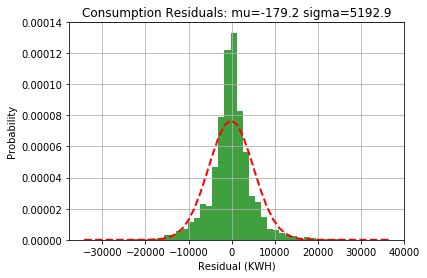

In [68]:
(mu, sigma) = norm.fit(residuals)

# the histogram of the data
n, bins, patches = plt.hist(residuals, 50, normed=1,facecolor='green', alpha=0.75)

# add a 'best fit' line
y = mlab.normpdf( bins, mu, sigma)
l = plt.plot(bins, y, 'r--', linewidth=2)

#plot
plt.xlabel('Residual (KWH)')
plt.ylabel('Probability')
plt.title(f'Consumption Residuals: mu={mu:.1f} sigma={sigma:.1f}')
plt.grid(True)

plt.show()

## Consumption with Electric Vehicle Energy

In [80]:
df = pd.read_csv('../processed/consumption_master_with_SF.csv')

## i guess i have to bring in consumption weather and join it to the consumption dataset

c_weather = pd.read_csv('../raw/powercity_weather_consumption.csv')

# create datetime index to join both tables
c_weather['Hour_str'] = [str(x-1) if len(str(x-1))==2 else '0'+str(x-1) for x in c_weather['Hour']]
c_weather['datetime_str'] = ['1900-'+str(x)+'-'+str(y)+' '+str(z)+':00:00' for x, y, z in zip(c_weather.Month, c_weather.Day, c_weather.Hour_str)]
c_weather['datetime'] = pd.to_datetime(c_weather.datetime_str, infer_datetime_format=True)

c_weather = c_weather.set_index(pd.DatetimeIndex(c_weather['datetime']))
c_weather.drop(['datetime', 'datetime_str', 'Hour_str', 'Year', 'City'], axis=1, inplace=True)

for field in ['Month', 'Day', 'Hour']:
    c_weather[field] = c_weather[field].astype(str)
    
# join to main consumption data
df = df.set_index(pd.DatetimeIndex(df['Time']))
df.drop('Time', inplace=True, axis=1)

model_df = df.merge(c_weather, left_index=True, right_index=True, how='inner')

model_df['Total_Consumption'] = df.ELECTRIC_CAR + df.FOOD_SVC_TOTAL + df.GROCERY_TOTAL + df.HEALTH_CARE_TOTAL + df.K12_TOTAL + df.LODGING_TOTAL + df.OFFICE_TOTAL + df.RESIDENTIAL_TOTAL + df.SA_RTL_TOTAL

columns_to_drop = ['FOOD_SERVICE', 
                   'GROCERY', 
                   'HEALTH_CARE', 
                   'K12_SCHOOLS',
                   'LODGING',
                   'OFFICE',
                   'RESIDENTIAL',
                   'STAND_ALONE_RETAIL',
                   'FOOD_SVC_TOTAL',
                   'GROCERY_TOTAL',
                   'HEALTH_CARE_TOTAL',
                   'K12_TOTAL',
                   'LODGING_TOTAL',
                   'OFFICE_TOTAL',
                   'RESIDENTIAL_TOTAL',
                   'SA_RTL_TOTAL']
                   
model_df.drop(columns_to_drop, inplace=True, axis=1)

# convert school day boolean to string
model_df.School_Day = model_df.School_Day.astype(str)

model_df_dummies = pd.get_dummies(model_df)

X = model_df_dummies.drop('Total_Consumption', axis=1)
y = model_df_dummies['Total_Consumption']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)


In [81]:
# final xgboost model
xg_reg = xgb.XGBRegressor(objective ='reg:linear', 
                          colsample_bytree = 0.56, 
                          learning_rate = 0.11,
                          max_depth = 19, 
                          reg_lambda = 43, 
                          n_estimators = 170)

xg_reg.fit(X_train,y_train)
train_preds = xg_reg.predict(X_train)
test_preds = xg_reg.predict(X_test)

test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))
train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
print(f'Train RMSE: {train_rmse:.2f}')
print(f'Test RMSE: {test_rmse:.2f}')

Train RMSE: 1776.23
Test RMSE: 4965.96


/Users/johnmatune/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/johnmatune/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:10: MatplotlibDeprecationWarning: scipy.stats.norm.pdf


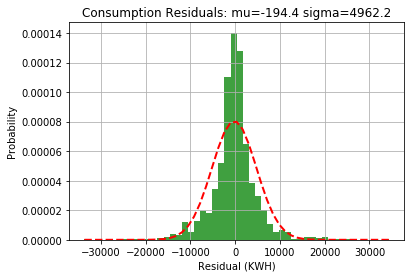

In [82]:
# residual plot
residuals = np.array(y_test - test_preds)

(mu, sigma) = norm.fit(residuals)

# the histogram of the data
n, bins, patches = plt.hist(residuals, 50, normed=1,facecolor='green', alpha=0.75)

# add a 'best fit' line
y = mlab.normpdf( bins, mu, sigma)
l = plt.plot(bins, y, 'r--', linewidth=2)

#plot
plt.xlabel('Residual (KWH)')
plt.ylabel('Probability')
plt.title(f'Consumption Residuals: mu={mu:.1f} sigma={sigma:.1f}')
plt.grid(True)

plt.show()

In [94]:
resid_series = pd.Series(residuals)
X_test.reset_index(inplace=True)
pd.concat([X_test, resid_series], axis=1)

,index,ELECTRIC_CAR,FOOD_SVC_SF,GROCERY_SF,HEALTH_CARE_SF,K12_SF,LODGING_SF,OFFICE_SF,RESIDENTIAL_SF,SA_RTL_SF,...,Hour_23,Hour_24,Hour_3,Hour_4,Hour_5,Hour_6,Hour_7,Hour_8,Hour_9,0
0,1900-01-17 06:00:00,0.000000,967558.098713,539981.116858,965374.296927,2426480.0,931129.090489,9.999731e+06,8.482341e+07,971961.735665,...,0,0,0,0,0,0,1,0,0,-11396.120027
1,1900-12-19 13:00:00,0.000000,967558.098713,539981.116858,965374.296927,2426480.0,931129.090489,9.999731e+06,8.482341e+07,971961.735665,...,0,0,0,0,0,0,0,0,0,277.227236
2,1900-05-30 13:00:00,0.000000,967558.098713,539981.116858,965374.296927,2426480.0,931129.090489,9.999731e+06,8.482341e+07,971961.735665,...,0,0,0,0,0,0,0,0,0,1054.566981
3,1900-07-31 23:00:00,22597.669011,967558.098713,539981.116858,965374.296927,2426480.0,931129.090489,9.999731e+06,8.482341e+07,971961.735665,...,0,1,0,0,0,0,0,0,0,-2935.935574
4,1900-05-21 07:00:00,0.000000,967558.098713,539981.116858,965374.296927,2426480.0,931129.090489,9.999731e+06,8.482341e+07,971961.735665,...,0,0,0,0,0,0,0,1,0,-4819.208508
5,1900-12-05 02:00:00,22597.669011,967558.098713,539981.116858,965374.296927,2426480.0,931129.090489,9.999731e+06,8.482341e+07,971961.735665,...,0,0,1,0,0,0,0,0,0,78.178734
6,1900-01-30 01:00:00,22597.669011,967558.098713,539981.116858,965374.296927,2426480.0,931129.090489,9.999731e+06,8.482341e+07,971961.735665,...,0,0,0,0,0,0,0,0,0,-370.887564
7,1900-04-26 20:00:00,0.000000,967558.098713,539981.116858,965374.296927,2426480.0,931129.090489,9.999731e+06,8.482341e+07,971961.735665,...,0,0,0,0,0,0,0,0,0,11085.993745
8,1900-04-11 04:00:00,22597.669011,967558.098713,539981.116858,965374.296927,2426480.0,931129.090489,9.999731e+06,8.482341e+07,971961.735665,...,0,0,0,0,1,0,0,0,0,1250.859768
9,1900-04-22 11:00:00,0.000000,967558.098713,539981.116858,965374.296927,2426480.0,931129.090489,9.999731e+06,8.482341e+07,971961.735665,...,0,0,0,0,0,0,0,0,0,-737.121734


In [93]:
X_test

,ELECTRIC_CAR,FOOD_SVC_SF,GROCERY_SF,HEALTH_CARE_SF,K12_SF,LODGING_SF,OFFICE_SF,RESIDENTIAL_SF,SA_RTL_SF,Cloud_Cover_Fraction,...,Hour_22,Hour_23,Hour_24,Hour_3,Hour_4,Hour_5,Hour_6,Hour_7,Hour_8,Hour_9
1900-01-17 06:00:00,0.000000,967558.098713,539981.116858,965374.296927,2426480.0,931129.090489,9.999731e+06,8.482341e+07,971961.735665,1.0,...,0,0,0,0,0,0,0,1,0,0
1900-12-19 13:00:00,0.000000,967558.098713,539981.116858,965374.296927,2426480.0,931129.090489,9.999731e+06,8.482341e+07,971961.735665,1.0,...,0,0,0,0,0,0,0,0,0,0
1900-05-30 13:00:00,0.000000,967558.098713,539981.116858,965374.296927,2426480.0,931129.090489,9.999731e+06,8.482341e+07,971961.735665,0.9,...,0,0,0,0,0,0,0,0,0,0
1900-07-31 23:00:00,22597.669011,967558.098713,539981.116858,965374.296927,2426480.0,931129.090489,9.999731e+06,8.482341e+07,971961.735665,0.5,...,0,0,1,0,0,0,0,0,0,0
1900-05-21 07:00:00,0.000000,967558.098713,539981.116858,965374.296927,2426480.0,931129.090489,9.999731e+06,8.482341e+07,971961.735665,0.0,...,0,0,0,0,0,0,0,0,1,0
1900-12-05 02:00:00,22597.669011,967558.098713,539981.116858,965374.296927,2426480.0,931129.090489,9.999731e+06,8.482341e+07,971961.735665,1.0,...,0,0,0,1,0,0,0,0,0,0
1900-01-30 01:00:00,22597.669011,967558.098713,539981.116858,965374.296927,2426480.0,931129.090489,9.999731e+06,8.482341e+07,971961.735665,0.4,...,0,0,0,0,0,0,0,0,0,0
1900-04-26 20:00:00,0.000000,967558.098713,539981.116858,965374.296927,2426480.0,931129.090489,9.999731e+06,8.482341e+07,971961.735665,1.0,...,0,0,0,0,0,0,0,0,0,0
1900-04-11 04:00:00,22597.669011,967558.098713,539981.116858,965374.296927,2426480.0,931129.090489,9.999731e+06,8.482341e+07,971961.735665,1.0,...,0,0,0,0,0,1,0,0,0,0
1900-04-22 11:00:00,0.000000,967558.098713,539981.116858,965374.296927,2426480.0,931129.090489,9.999731e+06,8.482341e+07,971961.735665,0.0,...,0,0,0,0,0,0,0,0,0,0


In [90]:
X.shape

(8759, 105)

In [103]:
df = pd.read_csv('../processed/consumption_master_with_SF.csv')

## i guess i have to bring in consumption weather and join it to the consumption dataset

c_weather = pd.read_csv('../raw/powercity_weather_consumption.csv')

# create datetime index to join both tables
c_weather['Hour_str'] = [str(x-1) if len(str(x-1))==2 else '0'+str(x-1) for x in c_weather['Hour']]
c_weather['datetime_str'] = ['1900-'+str(x)+'-'+str(y)+' '+str(z)+':00:00' for x, y, z in zip(c_weather.Month, c_weather.Day, c_weather.Hour_str)]
c_weather['datetime'] = pd.to_datetime(c_weather.datetime_str, infer_datetime_format=True)

c_weather = c_weather.set_index(pd.DatetimeIndex(c_weather['datetime']))
c_weather.drop(['datetime', 'datetime_str', 'Hour_str', 'Year', 'City'], axis=1, inplace=True)

    
# join to main consumption data
df = df.set_index(pd.DatetimeIndex(df['Time']))
df.drop('Time', inplace=True, axis=1)

model_df = df.merge(c_weather, left_index=True, right_index=True, how='inner')

model_df['Total_Consumption'] = df.ELECTRIC_CAR + df.FOOD_SVC_TOTAL + df.GROCERY_TOTAL + df.HEALTH_CARE_TOTAL + df.K12_TOTAL + df.LODGING_TOTAL + df.OFFICE_TOTAL + df.RESIDENTIAL_TOTAL + df.SA_RTL_TOTAL

columns_to_drop = ['FOOD_SERVICE', 
                   'GROCERY', 
                   'HEALTH_CARE', 
                   'K12_SCHOOLS',
                   'LODGING',
                   'OFFICE',
                   'RESIDENTIAL',
                   'STAND_ALONE_RETAIL',
                   'FOOD_SVC_TOTAL',
                   'GROCERY_TOTAL',
                   'HEALTH_CARE_TOTAL',
                   'K12_TOTAL',
                   'LODGING_TOTAL',
                   'OFFICE_TOTAL',
                   'RESIDENTIAL_TOTAL',
                   'SA_RTL_TOTAL']
                   
model_df.drop(columns_to_drop, inplace=True, axis=1)

# convert school day boolean to string
model_df.School_Day = model_df.School_Day.astype(str)

X = model_df.drop('Total_Consumption', axis=1)
y = model_df['Total_Consumption']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [104]:
X_test.reset_index(inplace=True)
model_resid_combined = pd.concat([X_test, resid_series], axis=1)

In [105]:
model_resid_combined.head()

,index,Weekdays,HolidayName,School_Day,Workday,ELECTRIC_CAR,FOOD_SVC_SF,GROCERY_SF,HEALTH_CARE_SF,K12_SF,...,Month,Day,Hour,Cloud_Cover_Fraction,Dew_Point,Humidity_Fraction,Precipitable_Water,Temperature,Visibility,0
0,1900-01-17 06:00:00,Tue,FALSE,1.0,True,0.000000,967558.098713,539981.116858,965374.296927,2426480.0,...,1,17,7,1.0,3.3,0.96,13,3.9,4.800000,-11396.120027
1,1900-12-19 13:00:00,Tue,FALSE,1.0,True,0.000000,967558.098713,539981.116858,965374.296927,2426480.0,...,12,19,14,1.0,-8.3,0.75,7,-4.0,18.766667,277.227236
2,1900-05-30 13:00:00,Tue,FALSE,0.0,True,0.000000,967558.098713,539981.116858,965374.296927,2426480.0,...,5,30,14,0.9,19.4,0.76,33,23.9,4.800000,1054.566981
3,1900-07-31 23:00:00,Mon,FALSE,0.0,True,22597.669011,967558.098713,539981.116858,965374.296927,2426480.0,...,7,31,24,0.5,17.9,0.71,28,22.8,24.000000,-2935.935574
4,1900-05-21 07:00:00,Sun,FALSE,0.0,False,0.000000,967558.098713,539981.116858,965374.296927,2426480.0,...,5,21,8,0.0,7.2,0.77,16,11.1,24.100000,-4819.208508


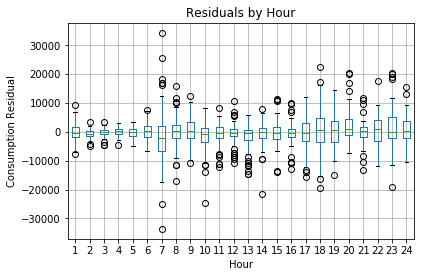

In [117]:
model_resid_combined.boxplot(column=0, by='Hour')
plt.title('Residuals by Hour')
plt.suptitle('')
plt.ylabel('Consumption Residual')
plt.show()

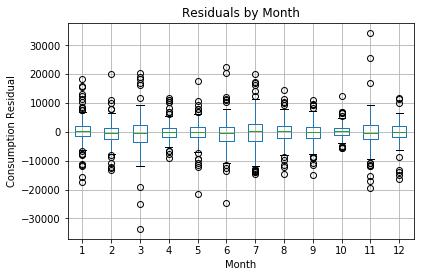

In [114]:
model_resid_combined.boxplot(column=0, by='Month')
plt.title('Residuals by Month')
plt.suptitle('')
plt.ylabel('Consumption Residual')
plt.show()

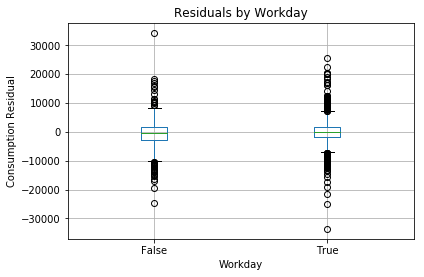

In [115]:
model_resid_combined.boxplot(column=0, by='Workday')
plt.title('Residuals by Workday')
plt.suptitle('')
plt.ylabel('Consumption Residual')
plt.show()

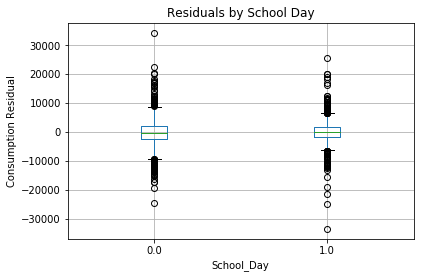

In [116]:
model_resid_combined.boxplot(column=0, by='School_Day')
plt.title('Residuals by School Day')
plt.suptitle('')
plt.ylabel('Consumption Residual')
plt.show()

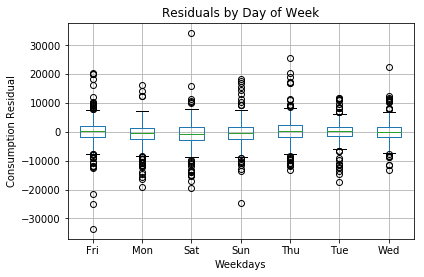

In [118]:
model_resid_combined.boxplot(column=0, by='Weekdays')
plt.title('Residuals by Day of Week')
plt.suptitle('')
plt.ylabel('Consumption Residual')
plt.show()